# Complete guide

## Introduction

This Notebook contains an overview of the basic functionality of the simulator. It introduces the simplest ways to get started with the simulator, and it dives into more advanced concepts that will allow you to get a sense of the flexibility of the system. At the end of this guide, you should be able to configure the pre-loaded simulations with custom parameters and metrics.

## Main components
The following diagram provides a birds-eye view of the simulation dynamics. (Note that the diagram does not include content creators, which are optional.)
<img src="figures/diagram.jpg" width=500>

A simulation needs the following components:

- **Users**: agents who interact with each other and with items.
- **Model**: agent that defines the behavior of the sociotechnical system. The model mediates the interactions among users and between users and the system.
- **Items**: passive components that are served to the users by the model. (Items may come from a fixed catalog or may be dynamically generated by **creators**.)
- **Measurements**: modules built into the models which automatically compute information about the system.

## Dynamics
The following steps are at the heart of the simulations:
1. The **model** presents the **users** with some recommended **items**. The recommendations are generated in accordance with the specific recommender system algorithm the model is using (e.g., content filtering, popularity, etc.). The input to the algorithm is based on the model's _prediction_ or _knowledge_ of user preferences.
2. The **users** view the items presented by the **model**, and interact with some **items** according to some _actual_ preferences.
3. The **model** updates its system state (such as the prediction of user preferences) based on the interactions of **users** with **items**, and it takes some **measurements**.

We will see that this framework is very flexible and it can be a generalization of many classic and new models.

## Quick start: instantiate a model and run
The fastest way to get started is to choose a model, instantiate it with no parameters, and run it for some time steps. Here we run a simple [content filtering recommendation system](https://elucherini.github.io/t-recs/reference/models.html#module-models.content) (please refer to the [BaseRecommender documentation](https://elucherini.github.io/t-recs/reference/models.html#module-models.recommender) for a complete list of class attributes and methods shared by all models, as that information is currently incomplete in the docs of the other pre-loaded models).

Content filters infer information about the _attributes_ of users based on their past interactions and recommend items with similar attributes to those of users.

In [1]:
import pandas as pd
import numpy as np

import trecs
from trecs.models import ContentFiltering
from trecs.random import Generator
from trecs.metrics import MSEMeasurement, InteractionSpread, RecSimilarity, AverageFeatureScoreRange, InteractionSimilarity

In [ ]:
# Create ContentFiltering instance without arguments
default_filtering = ContentFiltering()
# add an MSE measurement
default_filtering.add_metrics(MSEMeasurement())
# Run for 5 time steps
default_filtering.run(timesteps=5)

In [ ]:
# Collect measurements about the simulation
results = default_filtering.get_measurements()

print("Results of the simulation:")
pd.DataFrame(results)

In what follows, we expand on this minimal example to gain a deeper understanding of what happens under the hood.

## Models

As in the ``Quick Start``, if you want to run a simulation, the smallest piece of information you need is the model you want to run. There are a number of pre-loaded models that work out of the box. We continue to use a generic content filtering recommendation system; please see the docs for a [list of already-implemented models](https://elucherini.github.io/t-recs/reference/models.html#).

Recall that content filters infer information about the _attributes_ of users based on their past interactions and recommend items with similar attributes to those of users.

In [ ]:
# Again, we instantiate the model with no arguments
default_filtering = ContentFiltering()

In the cell above, we instantiated a content filtering recommender system with default parameters. We print below the default number of users and items in the system.

In [ ]:
print(f"Number of users in system: {default_filtering.num_users}")
print(f"Number of items in system: {default_filtering.num_items}")

The model also created a representation for both users and items.

In [ ]:
print("In content filtering, the default model representation of users and items are given by:")
print(f"- An all-zeros matrix of users of dimension {default_filtering.predicted_user_profiles.shape}")
print(f"- A randomly generated matrix of items of dimension {default_filtering.predicted_item_attributes.shape}")

Formally, content filtering supports user profiles of size `|num_users x num_attributes|` and item attributes of size `|num_attributes x num_items|`.

### Set number of users or items
We can customize the number of users and items in the system:

In [ ]:
# instantiate with a different number of items and users
number_of_items = 5000
number_of_users = 500
filtering = ContentFiltering(num_items = number_of_items, num_users=number_of_users)
print(f"The number of items in the system is now {filtering.num_items}.")
print(f"The number of users in the system is now {filtering.num_users}.")

Note that the representations of items and users are set accordingly:

In [ ]:
print(f"The size of item_attributes is {filtering.predicted_item_attributes.shape}.")
print(f"The size of user_profiles is {filtering.predicted_user_profiles.shape}.")

## User predictions and Items
We might also want to define our own representation of users and items. We can do so by defining matrices that satisfy the constraints of the model. The constraints for ContentFiltering (some of which have been mentioned above) are:

- User profiles must be of size `|num_users x num_attributes|`.
- User profiles are matrices of integers representing the number of interactions of each user with items that have a given attributes. `user_profiles[i, j]` represents the number of interactions user `i` had with items with attribute `j`.
- Item attributes must be of size `|num_attributes x num_items|`.
- The model doesn't define any constraint on item attributes. If `item_attributes` is binary, then its `[i, j]`th element is 1 if item `j` is attributed attribute `i`; otherwise, it's 0. Item attributes can also be real-valued, representing the probability that each attribute has to describe items.

If you're already familiar with Numpy: the model is compatible with `ndarray` and _array_like_ data structures. 

If you're not familiar with Numpy: the framework provides a random number generator that lets you draw from several distributions (which, in practice, is a thin wrapper around `numpy.random.Generator`). Please refer to the Numpy documentation for a [list of distributions](https://numpy.org/doc/stable/reference/random/generator.html?highlight=generator#distributions).

In [ ]:
# Keep the dimensions small for easy visualization
number_of_users = 5
number_of_attributes = 10
number_of_items = 15
# We define user_representation using the standard integer generator in Numpy.
# We assume a number of interactions with each attribute in the interval [0,4).
user_representation = np.random.randint(4, size=(number_of_users, number_of_attributes))

# We define item_representation using the Generator that comes with the framework
# We assume a binary matrix with a binomial distribution

item_representation = Generator().binomial(
    n=1, p=.3, size=(number_of_attributes, number_of_items)
)
# Note that this is equivalent to:
# item_representation = np.random.Generator(np.random.MT19937()).binomial(n=1, p=.5, size=(...))

print(f"User representation (num_users x num_attributes):\n{str(user_representation)}\n")
print(f"Item representation (num_attributes x num_items):\n{str(item_representation)}")

In [ ]:
# Initialize with custom representations
filtering = ContentFiltering(user_representation=user_representation,
                             item_representation=item_representation)

# Check if they're equivalent
is_user_equivalent = "yes" if np.array_equal(user_representation, filtering.predicted_user_profiles) else "no"
is_item_equivalent = "yes" if np.array_equal(item_representation, filtering.predicted_item_attributes) else "no"
print("Is user_profiles equivalent to user_representation? %s." % is_user_equivalent)
print("Is item_attributes equivalent to item_representation? %s." % is_item_equivalent)

You can also initialize models with `user_representation` and `item_representation` individually. In this case, the representation that has not been initialized will adapt to the size defined by the user.

In [ ]:
# Let's only initialize user_profiles
filtering = ContentFiltering(user_representation=user_representation)
print("After initializing user_profiles, the size of item_attributes (and so the number of attributes in the system) adapts automatically to it.")
print(f"Size of user_profiles, as defined above: {str(filtering.predicted_user_profiles.shape)}.")
print(f"Size of item_attributes: {str(filtering.predicted_item_attributes.shape)}.\n")

# The same happens by only initializing item_attributes
filtering = ContentFiltering(item_representation=item_representation)
print("After initializing item_attributes, the size of user_profiles (and so the number of attributes in the system) adapts automatically to it.")
print(f"Size of item_attributes, as defined above: {str(filtering.predicted_item_attributes.shape)}.")
print(f"Size of user_profiles: {str(filtering.predicted_user_profiles.shape)}.")

## Run a simulation
We can run a simulation for the predefined number of time steps (50), or define our own duration.

In [ ]:
# let's initialize a model with both user_representation and item_representation defined above
filtering = ContentFiltering(user_representation=user_representation,
                            item_representation=item_representation)
filtering.add_metrics(MSEMeasurement()) # add MSE Measurement
# Run the model for the predefined number of timesteps:
filtering.run()

At the end of the simulation, we can examine the results of the measurements. For example:

In [ ]:
# To get the measurements of all timesteps<=50
measurements = filtering.get_measurements()

# Measurements can be easily converted to pandas DataFrame objects

pd.DataFrame(measurements).head()

## Measurements
At each time step of the simulation, measurement modules calculate a quantity based on the system state. An example of such quantity is the mean squared error between the predicted user profiles and the actual user profiles -- that is, how close is the model to predicting the real preferences of the system?

It's easy to define new metrics, but in this guide we will use some of the pre-loaded metrics to get a better sense of how they work. For a list of pre-loaded metrics and their descriptions, see the [docs](https://elucherini.github.io/t-recs/reference/metrics.html).

### View metrics

The metrics monitored are stored in the the model's `metrics` attribute, which contains a list of objects of type [Measurement](https://elucherini.github.io/t-recs/reference/metrics.html#measurement-base-class).

In [ ]:
# The metrics tracked by each model can be examined by printing the `metrics` list.
print("The system is currently monitoring these metrics:")
print(filtering.metrics)

### Add metrics
To **maintain compatibility with pandas**, we suggest to **only add metrics to instances of models that have not been run yet**. This is to avoid having measurements that start at different time steps, resulting in arrays of different length. Feel free to disregard this advice if pandas compatibility is not important to your application.

We can instantiate a model, add a new metric, and then run the model.

We will add InteractionSpread, which provides a measure of the homogeneity of user interactions in the system as a whole.



In [ ]:
#change the number of items and users to make metric values more reasonable and dimensions distinguishable
number_of_items=100
number_of_users=50
number_of_attributes=20

#change the distribution of item attributes so average feature score range can be added later
item_representation = Generator().normal(size=(number_of_attributes, number_of_items))
filtering = ContentFiltering(num_users=number_of_users, num_items=number_of_items, 
                             num_attributes=number_of_attributes,
                             item_representation=item_representation,
                             record_base_state=True)

# This method accepts a variable number of metrics
filtering.add_metrics(MSEMeasurement(), InteractionSpread())

print("These are the current metrics:")
print(filtering.metrics)

We will also add [RecSimilarity](https://elucherini.github.io/t-recs/reference/metrics.html#recsimilarity), which measures the similarity between interaction patterns for pairs of users. In order to measure Jaccard similarity, we must specify which pairs of users we want to compare.

In [ ]:
js_pairs = [(u1_idx, u2_idx) for u1_idx in range(filtering.num_users) for u2_idx in range(filtering.num_users) if u1_idx != u2_idx] 
filtering.add_metrics(RecSimilarity(pairs=js_pairs))

print("These are the current metrics:")
print(filtering.metrics)

Now we will add average feature score range, a metric for evaluating within list diversity based on the range of item attribute values

In [ ]:
filtering.add_metrics(AverageFeatureScoreRange())

In [ ]:
# now we run the model
filtering.run(timesteps=5)
measurements = filtering.get_measurements()
pd.DataFrame(measurements)

Measurements at time step 0 can be undefined (`None`, `NaN`, etc.) because it denotes the measurements before the start of the simulation. MSE is defined at the beginning because the system is initialized with random predictions of the user profiles; in contrast, homogeneity is meaningless before the simulation begins because there are no user interactions to consider.

### Add diagnostics
You can also add diagnostics on the data you are using to calculate your metrics. Diagnostic statistics can be calculated for mean squared error across users. The statistics that are calculated include the mean, standard deviation, median, mean, max, skew, kurtosis, Shapiro-Wilk statistic (for testing distribution normality) and its associated p-value for sample sizes less than 5,000. You can also generate either histograms of the metric distribution, Q-Q plots, or both. 

In [ ]:
default_filtering = ContentFiltering()

js_pairs = [(u1_idx, u2_idx) for u1_idx in range(default_filtering.num_users) for u2_idx in range(default_filtering.num_users) if u1_idx != u2_idx] 

# add an MSE measurement
default_filtering.add_metrics(MSEMeasurement(diagnostics=True, plot=["qq", "hist"]))
default_filtering.add_metrics(InteractionSimilarity(pairs=js_pairs, diagnostics=True, plot=["hist"]))

default_filtering.run(timesteps=10)

In [ ]:
#This is the weird part. Would be better to get this to function the same as "get_measurements"
mse_diagnostics = default_filtering.metrics[0].get_diagnostics()
isim_diagnostics = default_filtering.metrics[1].get_diagnostics()

mse_diagnostics.head()

In [ ]:
isim_diagnostics.head()

In [4]:
import matplotlib.pyplot as plt

In [9]:
number_of_attributes = 10
number_of_maj_users = 150
number_of_min_users = 50

maj_user_representation = np.random.normal(1, 2, size=(number_of_maj_users, number_of_attributes))
min_user_representation = np.random.normal(0.5, 1.25, size=(number_of_min_users, number_of_attributes))
actual_user_representation = np.vstack((maj_user_representation, min_user_representation))

(array([ 3.,  8., 15., 32., 44., 37., 38., 12.,  8.,  3.]),
 array([-0.64536275, -0.34695945, -0.04855616,  0.24984714,  0.54825043,
         0.84665373,  1.14505703,  1.44346032,  1.74186362,  2.04026691,
         2.33867021]),
 <BarContainer object of 10 artists>)

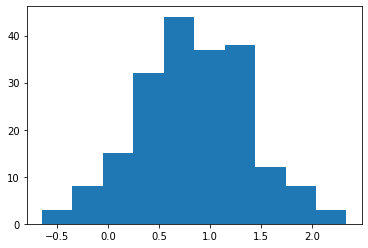

In [10]:
#If plotted without respect to the subgroups, preference means look more or less normally distributed
plt.hist(actual_user_representation.mean(axis=1))

(array([ 1.,  4.,  5.,  7., 11., 10.,  7.,  2.,  2.,  1.]),
 array([-0.47686814, -0.27394321, -0.07101829,  0.13190664,  0.33483157,
         0.5377565 ,  0.74068143,  0.94360635,  1.14653128,  1.34945621,
         1.55238114]),
 <BarContainer object of 10 artists>)

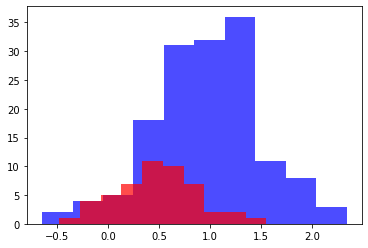

In [11]:
#when plotting out mean preferences when accounting for group, we can see a clear distinction in preference
plt.hist(maj_user_representation.mean(axis=1), alpha=.7, color='b')
plt.hist(min_user_representation.mean(axis=1), alpha=0.7, color='r')

In [12]:
filtering = ContentFiltering(actual_user_representation=actual_user_representation, 
                             num_attributes=number_of_attributes,
                             num_items=500)



filtering.add_metrics(MSEMeasurement(diagnostics=True, plot=["hist"], split_index=number_of_maj_users+1))

filtering.startup_and_train(50)
filtering.run(450)

100%|██████████| 450/450 [01:16<00:00,  5.87it/s]


In [ ]:
mse_diagnostics = filtering.metrics[0].get_diagnostics()
mse_beginning = mse_diagnostics.loc[50:, :]
mse_beginning.head()

In [ ]:
mse_end = mse_diagnostics.loc[495:, :]
mse_end.head()

## System state


Some applications might require keeping a history of the system's internal state for future processing. This is useful, for example, to study the evolution of predicted user profiles. The framework provides an interface to store and access all the states of each component over time through the `SystemStateModule` interface. Some components are tracked by default, others are added into the individual models.

In [ ]:
# note that we instantiated filtering with the option record_base_state=True
system_state = filtering.get_system_state()
print("These are the system state components being monitored:")
print(system_state.keys())

In [ ]:
print("There are as many states as the timesteps for which we ran the system + the initial state.")
print("For example, the history of predicted_user_profiles has length:", (len(system_state['predicted_users'])))
# the last states correspond to the current state of the components
print("Furthermore, the last state is in the history of a component corresponds to its current state.")
print("Is this true for predicted_user_profiles?", np.array_equal(system_state['predicted_users'][5], filtering.predicted_user_profiles))

To start tracking a new component, you can use the [add_state_variable()](https://elucherini.github.io/t-recs/reference/components.html#base.base_components.SystemStateModule.add_state_variable). Note that state variables can only be monitored if they must inherit from the `BaseComponent` class. Creating new state variables is outside of the scope of this guide, so please refer to the [advanced-models](advanced-models.ipynb) and the [advanced-metrics](advanced-metrics.ipynb) notebooks.

## "Real" users, "real" items
Most of what we've seen so far about users refers to the predictions that the system makes about users' preferences and the item attributes. This framework allows for modeling system predictions as well as "real" users and items. These "real" user and item attributes can be passed into the simulation model; while they remain invisible by the recommender system algorithm, they dictate which items users interact with, and this interaction data is what the recommender system uses to continually retrain.

By default, the preference ordering over items for a particular user is defined by the dot product between the item profile and the user profile. You can

In [ ]:
# consider a toy example where all users have a very strong preference for items with the attribute at index 0,
# and only the first item has the attribute at index 0

# each row is a user
real_users = np.array([
    [1, 0, 0, 0, 0.7],
    [1, 0, 0.1, 0, 0],
    [1, 0, 0, 0.2, 0],
    [1, 0, 0.5, 0, 0],
])

# each column is an item
real_items = np.array([
    [1.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.1, 0.0, 0.2, 0.0],
    [0.0, 0.0, 0.2, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.3],
    [0.1, 0.1, 0.2, 0.3, 0.0],
])

# instantiate content filtering model; note that the system's internal model of
# each user's preferences over items will essentially be random
# we set the number of items shown to users at each iteration to be 5
filtering = ContentFiltering(actual_user_representation=real_users,
                             actual_item_representation=real_items,
                             num_items_per_iter=5)

In [ ]:
# Now when we run the model, we can look at the most recent recommendations
# and the items the users actually interacted with
filtering.run(timesteps=1)
print("Items shown to each user during the first timestep (row = one user)")
print(filtering.items_shown)

print()
print("Items each user chose to interact with (item at index i represents the item user i chose)")
print(filtering.interactions)

print()
filtering.run(timesteps=1)
print("Items shown to each user during the second timestep (row = one user).")
print("Note that the the first item shown is item 0, indicating the recommender system has learned the users' preferences.")
print(filtering.items_shown)

### User interactions with items
The Users class also determines how users interact with items. The default behavior is defined in [get_user_feedback()](https://elucherini.github.io/t-recs/reference/components.html#components.users.Users.get_user_feedback). In short, when the system presents items to users, users internally evaluate the items and choose the one item that maximizes the dot product between their own preferences and the item attributes. This default behavior can be overriden to provide a custom model of user-item interaction (for an example, see [DNUsers](https://elucherini.github.io/t-recs/reference/components.html#components.users.DNUsers)).

## Model parameters about user interactions
Models also provide a few initialization parameters that can be used to tweak the behavior of the model in regards to user interactions. Specifically, models determine the number of items to present users at each iteraction through parameter `num_items_per_iter`. The default is 10 items per user per iteration.

### Other model parameters
Please refer to [the docs](https://elucherini.github.io/algo-segregation/reference/models.html).